1. National line plot
2. Fixed regression? R2? across all years
3. Scatterplot
4. Predict next year's GDP using NTL

Sub-national
1. NUTS3 national plot
2. NUTS3 fixed regression, R2 (all regions all years)
3. Scatter all regions byyear/distribution of all regions by  year
4. Predict next years's GDP using NTL

# Analysis of Germany GDP versus harmonized nighttime lights

In [1]:
from analysis.eu_gdp_vs_ntl import *
from harmonizer.main import crop_batch
from harmonizer.plots import plot_timeseries
from harmonizer.diagnostics import get_series
from harmonizer.config import OUTPUT, DMSP_CLIP, VIIRS_CLIP, DATA, VIIRS_IN, DMSP_IN, ROOT

GDPFPATH= Path(ROOT,"files","nama_10r_3gdp.csv")
GEOMPATH = Path(ROOT,"data","geo","ref-nuts-2016-01m.geojson","NUTS_RG_01M_2016_4326.geojson")

## Get unprocessed VIIRS-DNB

1. This notebooks assumes the harmonizer has already been run on Germany and the harmonized time series is located in the `output/` folder.

2. We'll clip the raw input VNL files for comparison:

In [2]:
def crop_raw(din, vin, dout, vout, roipath):
    vout.mkdir(exist_ok=True)
    dout.mkdir(exist_ok=True)
    crop_batch(din, dout, roipath, 1)
    crop_batch(vin, vout, roipath, 1)
    
def normseries(series):
    series = np.asarray(series)
    return (series - np.mean(series)) / np.std(series)
    
DMSP_RAWDE = Path(DATA, "germany_rawDMSP")
VIIRS_RAWDE = Path(DATA, "germany_rawVIIRS")
OUTPUTDE = Path(OUTPUT, "gadm36_DEU_0__XGB")
roipathde = Path(ROOT, "roifiles/gadm36_DEU_shp/gadm36_DEU_0.shp")


DMSP_RAWIT = Path(DATA, "italy_rawDMSP")
VIIRS_RAWIT = Path(DATA, "italy_rawVIIRS")
OUTPUTIT = Path(OUTPUT, "gadm36_ITA_0__XGB")
roipathit = Path(ROOT, "roifiles/gadm36_ITA_shp/gadm36_ITA_0.shp")

DMSP_RAWFR = Path(DATA, "france_rawDMSP")
VIIRS_RAWFR = Path(DATA, "france_rawVIIRS")
OUTPUTFR = Path(OUTPUT, "gadm36_FRA_0__XGB")
roipathfr = Path(ROOT, "roifiles/gadm36_FRA_shp/gadm36_FRA_0.shp")

DMSP_RAWES = Path(DATA, "spain_rawDMSP")
VIIRS_RAWES = Path(DATA, "spain_rawVIIRS")
OUTPUTES = Path(OUTPUT, "gadm36_ESP_0__XGB")
roipathes = Path(ROOT, "roifiles/gadm36_ESP_shp/gadm36_ESP_0.shp")

# to create the clipped "raw" files (only needs to be done once)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWDE, VIIRS_RAWDE, roipathde)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWIT, VIIRS_RAWIT, roipathit)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWFR, VIIRS_RAWFR, roipathfr)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWES, VIIRS_RAWES, roipathes)

In [3]:
de_ntl = extract_time_series("DE",DMSP_RAWDE, VIIRS_RAWDE, OUTPUTDE, 1, 1)
it_ntl = extract_time_series("IT",DMSP_RAWIT, VIIRS_RAWIT, OUTPUTIT, 1, 1)
# fr_ntl = extract_time_series("FR",DMSP_RAWFR, VIIRS_RAWFR, OUTPUTFR, 1, 1)
es_ntl = extract_time_series("ES",DMSP_RAWES, VIIRS_RAWES, OUTPUTES, 1, 1)

100%|██████████| 8/8 [00:00<00:00, 36.40it/s]


In [4]:
gdp = load_gdp(GDPFPATH)
gdf = gpd.read_file(GEOMPATH)

In [5]:
de_gdp, de_geoms = get_country_data("DE",gdp, gdf, de_ntl)
it_gdp, it_geoms = get_country_data("IT",gdp, gdf, it_ntl)
# fr_gdp, fr_geoms = get_country_data("FR",gdp, gdf, fr_ntl)
es_gdp, es_geoms = get_country_data("ES",gdp, gdf, es_ntl)

In [6]:
def all_ts(dfs, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        df = df.rolling(3).mean()
        compare_ts_plot(df, gdpcol, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, title)
        
def all_scatter(dfs, ntl_un, ntladj, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        df = df.rolling(3).mean()
        compare_scatter(df, gdpcol, ntl_un, ntladj, title)

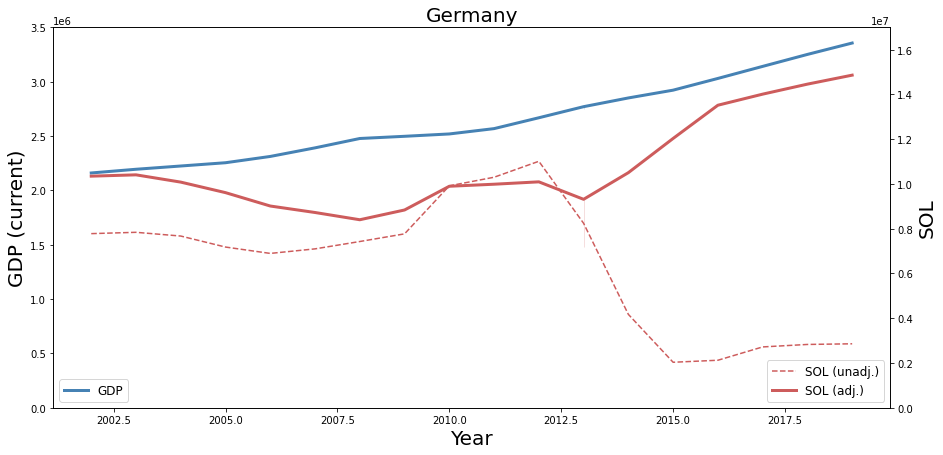

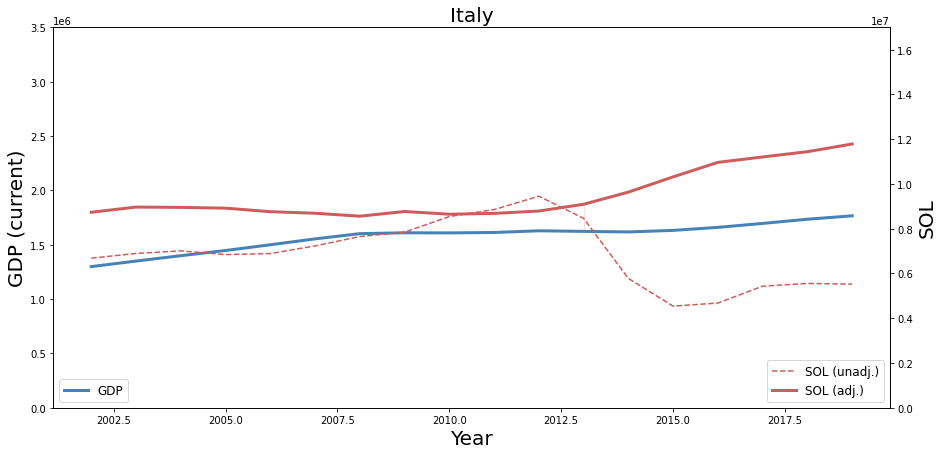

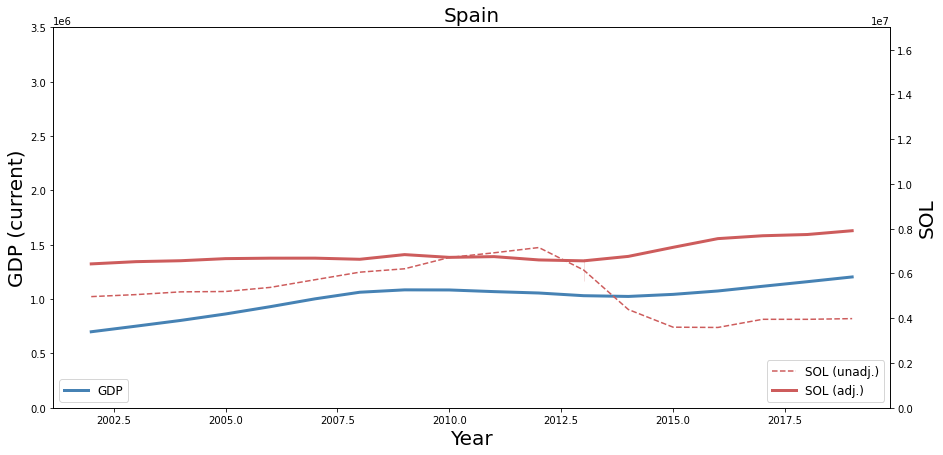

In [7]:
all_ts([de_gdp, it_gdp, es_gdp], "unadj_sol", "adj_sol", "SOL (unadj.)", "SOL (adj.)",
           "SOL", ["Germany","Italy","Spain"])

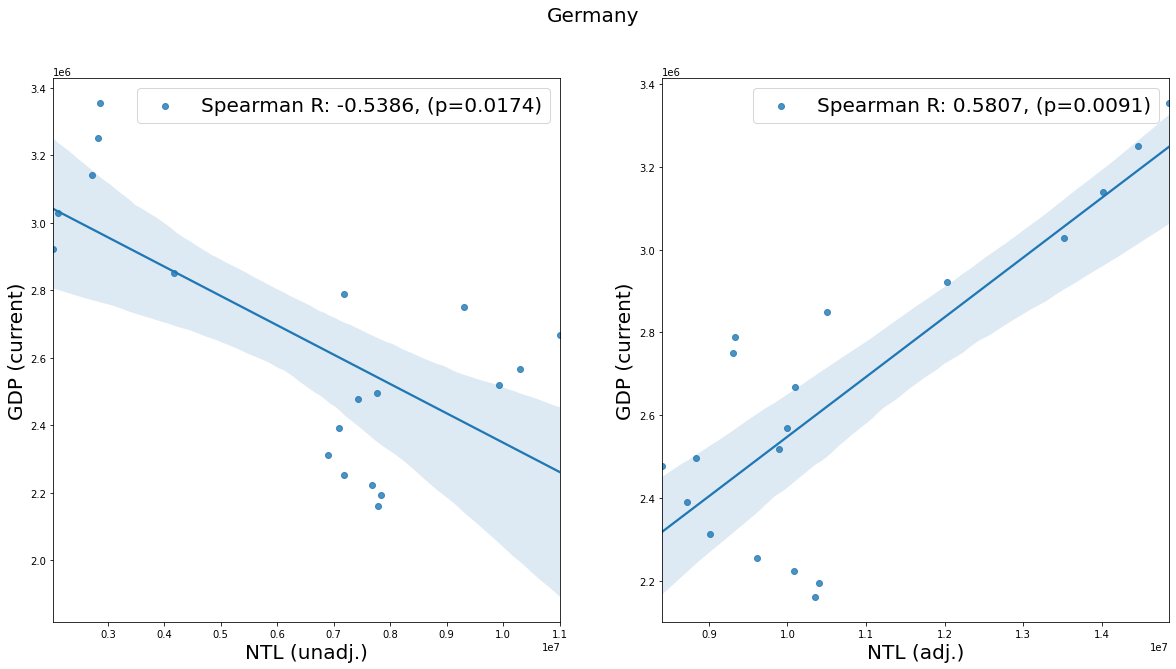

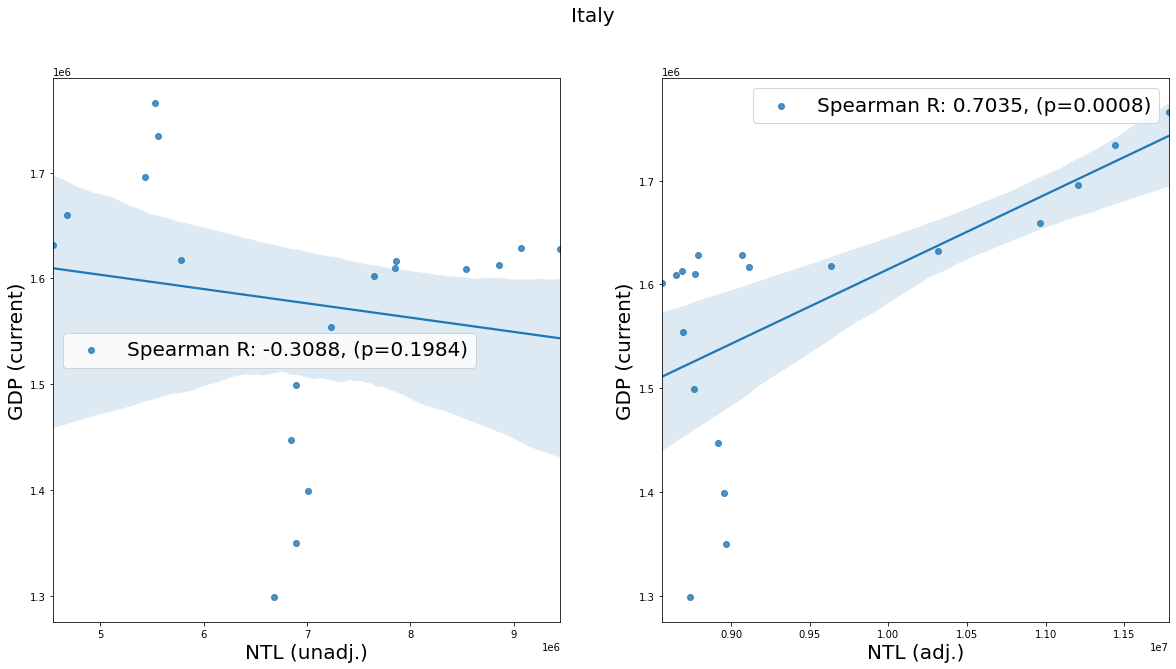

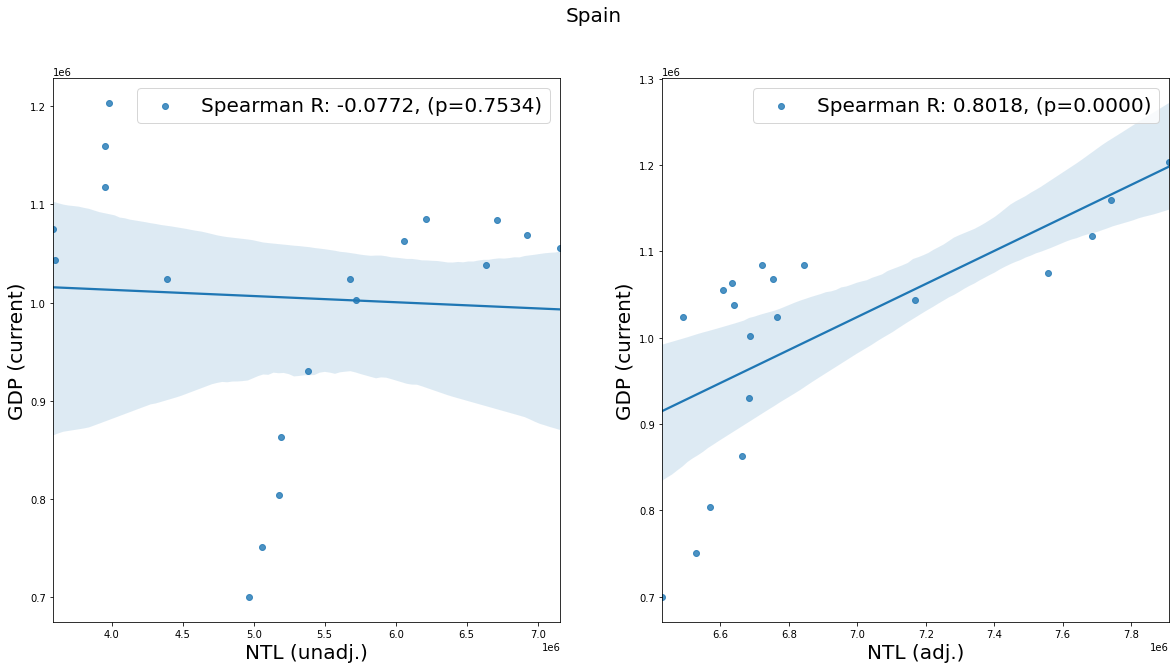

In [8]:
all_scatter([de_gdp, it_gdp, es_gdp], "unadj_sol", "adj_sol", ["Germany", "Italy", "Spain"], gdpcol="GDP")